## Assignment 9: Oversampling, undersampling, and SVM

Make sure you are using functions. You will lose 2 pts if there are no functions in your code. Chapter 16 should have some important information related to SVM, otherwise, the material from class and referenced below should suffice for this. Use words to explain the results. Do not just show a confusion matrix or classification report.
- Use type hints and make sure all your code except the import statements uses functions. 

1. Perform additional cleaning beyond what you did in Assignment 6. Specify the improvements you made.

In [41]:
import pandas as pd
from typing import Dict, List
from sklearn.preprocessing import MinMaxScaler

# Original cleaning methods, converted into broadly applicable functions complete with type hints:

def read_csv(files: List[str], on: str) -> pd.DataFrame:
    """Reads CSV files and merges them on a specified merge column"""
    dfs = [pd.read_csv(file) for file in files]
    combined_df = pd.merge(*dfs, on = on, how = "inner")
    return combined_df

def ffill_null_num(df: pd.DataFrame, method: str = 'ffill') -> pd.DataFrame:
    """Forward fills null numerical values in DataFrame"""
    df.fillna(method = method, inplace = True)
    return df

def map_ordinal_values(df: pd.DataFrame, mappings: Dict[str, Dict[str, int]]) -> pd.DataFrame:
    """Maps ordinal values in DataFrame onto specified values"""
    for column, mapper in mappings.items():
        df[column] = df[column].map(mapper)
    return df

def one_hot_encode(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """Performs one-hot encoding on specified columns of DataFrame."""
    df = pd.get_dummies(df, columns = columns)
    return df

# New, broadly applicable cleaning methods, also in functions, with respective type hints:

# 1.) Standardize the data so it has equal weight in the model's computation:

def scale_num(df: pd.DataFrame, columns_to_scale: List[str]) -> pd.DataFrame:
    """Scales specified numerical columns using MinMaxScaler"""
    scaler = MinMaxScaler()
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    return df

# 2.) Fills null CATEGORICAL values in dataframe with mode (most frequent) value of that column:

def fill_null_cats(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """Fills missing values in categorical columns with mode (most frequent value) of that column"""
    return df.apply(lambda x: x.fillna(x.mode()[0]))

# Newly cleaned data:

def clean_cc_data(main_data: str,
                  label_data: str,
                  ordinal_maps: Dict[str, Dict[str, int]],
                  cat_missing_fill_cols: List[str],
                  one_hot_cols: List[str],
                  numerical_cols: List[str]) -> pd.DataFrame:
    """Cleans credit card data"""
    cc_data = [main_data, label_data]
    cc_combined_df = read_csv(cc_data, on = "Ind_ID")
    cc_combined_df = map_ordinal_values(cc_combined_df, ordinal_maps)
    cc_combined_df = fill_null_cats(cc_combined_df, cat_missing_fill_cols)
    cc_combined_df = ffill_null_num(cc_combined_df)
    cc_combined_df = scale_num(cc_combined_df, numerical_cols)
    cc_combined_df = one_hot_encode(cc_combined_df, one_hot_cols)
    return cc_combined_df

main_data = "../Misc./Credit_card.csv"
label_data = "../Misc./Credit_card_label.csv"
ordinal_maps = {"EDUCATION": {"Lower secondary": 1, "Secondary / secondary special": 2, "Incomplete higher": 3,
                                  "Higher education": 4, "Academic degree": 5}}
cat_missing_fill_cols = ["GENDER", "Car_Owner", "Propert_Owner", "Type_Income", "Marital_status", "Housing_type", "Type_Occupation"]
one_hot_cols = ["GENDER", "Car_Owner", "Propert_Owner", "Type_Income", "Marital_status", "Housing_type", "Type_Occupation"]
numerical_cols = ["Annual_income", "Birthday_count", "Employed_days", "Family_Members"]
cleaned_cc_data = clean_cc_data(main_data, label_data, ordinal_maps, cat_missing_fill_cols, one_hot_cols, numerical_cols)

/var/folders/jq/xzwg3k5d0nqb3574ynkvzc740000gn/T/ipykernel_71032/942027036.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method = method, inplace = True)


2. Perform combined, oversampling, or undersampling on the dataset you selected for Assignment 6.  Explain why you chose what you did. How did this impact the results of your KNN and Logistic Regression? 

In [43]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from typing import Tuple

# Original KNN classification model, optimal k, and accuracy plugged into function format:

def train_knn(X_train: np.ndarray, y_train: np.ndarray, k: int) -> KNeighborsClassifier:
    """Trains a KNN classifier with the given training data and k value."""
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    return knn

def select_optimal_k(X_train: np.ndarray, y_train: np.ndarray, max_k: int = 13, cv: int = 5) -> int:
    """Selects the optimal value of k using cross-validation."""
    optimal_k = 1
    max_score = 0
    for k in range(1, max_k + 1):
        knn = KNeighborsClassifier(n_neighbors = k)
        scores = cross_val_score(knn, X_train, y_train, cv = cv)
        avg_score = np.mean(scores)
        if avg_score > max_score:
            max_score = avg_score
            optimal_k = k
    return optimal_k

def train_and_evaluate_knn(X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray) -> Tuple[int, float]:
    """Trains a KNN classifier, selects the optimal k, and evaluates its performance."""
    optimal_k = select_optimal_k(X_train, y_train)
    knn = train_knn(X_train, y_train, optimal_k)
    accuracy = knn.score(X_test, y_test)
    return optimal_k, accuracy


X = cleaned_cc_data.drop(columns = ['Ind_ID', 'EMAIL_ID', 'label'])
y = cleaned_cc_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 9383028)

optimal_k, accuracy = train_and_evaluate_knn(X_train, X_test, y_train, y_test)

print("Optimal K is:", optimal_k)
print("Accuracy:", accuracy)

Optimal K is: 4
Accuracy: 0.8817204301075269


In [44]:
cleaned_cc_data['label'].value_counts()

label
0    1373
1     175
Name: count, dtype: int64

In [45]:
# I chose Oversampling, because of the imbalance in the data skewed towards credit card approvals.
# As can be seen in the value_counts above, there is a ratio of nearly 10 approvals to 1 denial,
# so I aimed to improve the model by feeding it more instances of this minority:

from imblearn.over_sampling import RandomOverSampler

def oversample_random(X: np.ndarray, y: np.ndarray, test_size: float = 0.3, random_state: int = 42) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Oversample with RandomOverSampler and split data back into train/test sets"""
    ros = RandomOverSampler(random_state = random_state)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = test_size, random_state = random_state)
    return X_train, X_test, y_train, y_test

X = cleaned_cc_data.drop(columns = ['Ind_ID', 'EMAIL_ID', 'label']).values
y = cleaned_cc_data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 9383028)

X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = oversample_random(X_train, y_train)

optimal_k, accuracy = train_and_evaluate_knn(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

print("Optimal K is:", optimal_k)
print("Accuracy:", accuracy)

Optimal K is: 1
Accuracy: 0.9270833333333334


Oversampling SIGNIFICANTLY improved the accuracy of the KNN model!

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split

# Original Logistic Regression model, also plugged into function format:

def lr_train(X_train: np.ndarray, y_train: np.ndarray) -> LogisticRegression:
    """Trains a logistic regression model."""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    logistic_reg = LogisticRegression()
    logistic_reg.fit(X_train_scaled, y_train)
    return logistic_reg

def lr_performance(logistic_reg: LogisticRegression, X_test_scaled: np.ndarray, y_test: np.ndarray) -> float:
    """Calculates the accuracy of the logistic regression model."""
    y_pred = logistic_reg.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

def train_and_evaluate_lr(X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray) -> float:
    """Trains a logistic regression model and evaluates its performance."""
    logistic_reg_model = lr_train(X_train, y_train)
    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(X_test)
    accuracy = lr_performance(logistic_reg_model, X_test_scaled, y_test)
    return accuracy

X = cleaned_cc_data.drop(columns = ['Ind_ID', 'EMAIL_ID', 'label']).values
y = cleaned_cc_data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 18030)

accuracy = train_and_evaluate_lr(X_train, X_test, y_train, y_test)
print(accuracy)

0.886021505376344


In [47]:
# Oversampled Logistic Regression:

oversampled_lr_model = lr_train(X_train_resampled, y_train_resampled)
accuracy = lr_performance(oversampled_lr_model, X_test_resampled, y_test_resampled)
print("Accuracy:", accuracy)

Accuracy: 0.5347222222222222


Oversampling SIGNIFICANTLY worsened the accuracy of the logistic regression model... which could be due to overfitting, or the fundamental difference between KNN CLASSIFYING, as opposed to Logistic Regression PREDICTING results.

3. Create an ROC Curve for the model and calculate the AUC.

AUC Score: 0.9248225580609337


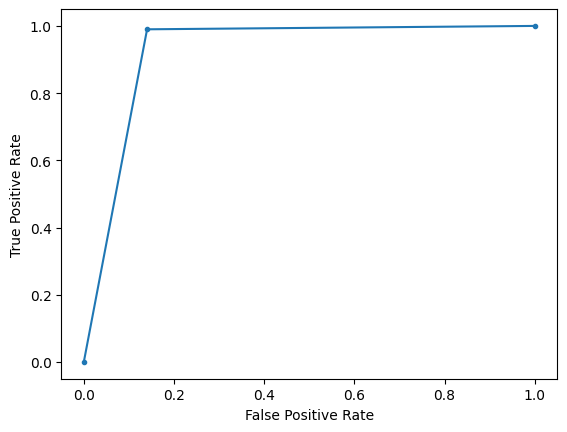

0.9248225580609337

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# KNN AUC and ROC Curve:

def knn_auc(knn_model: KNeighborsClassifier, X_test_scaled: np.ndarray, y_test: np.ndarray) -> float:
    """Calculates AUC and plots ROC curve for given KNN model"""
    y_pred_proba = knn_model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    return auc

def evaluate_knn_auc(X_test_scaled: np.ndarray, y_test: np.ndarray) -> float:
    """Evaluates AUC of given KNN model"""
    auc = knn_auc(knn_model, X_test_scaled, y_test)
    print("AUC Score:", auc)
    plt.show()
    return auc

evaluate_knn_auc(X_test_resampled, y_test_resampled)

AUC Score: 0.5984983825020521


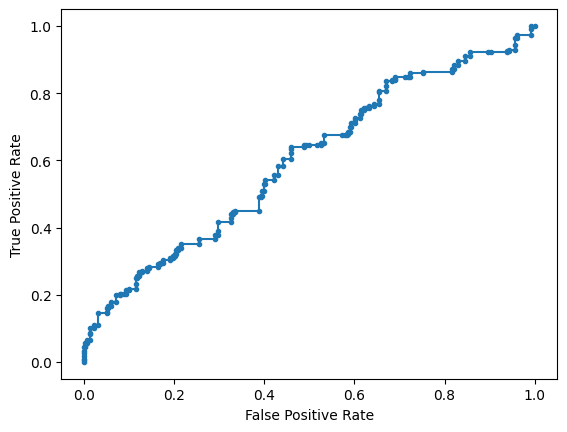

0.5984983825020521

In [59]:
# Logistic regression AUC and ROC curve:

def lr_auc(logistic_reg: LogisticRegression, X_test_scaled: np.ndarray, y_test: np.ndarray) -> float:
    """Calculates the AUC and plots the ROC curve of the logistic regression model."""
    y_pred_proba = logistic_reg.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, marker ='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    return auc

def evaluate_lr_auc(X_test_scaled: np.ndarray, y_test: np.ndarray) -> float:
    """Evaluates the AUC of the logistic regression model."""
    auc = lr_auc(oversampled_lr_model, X_test_scaled, y_test)
    print("AUC Score:", auc)
    plt.show()
    return auc

evaluate_lr_auc(X_test_resampled, y_test_resampled)

4. Perform a linear SVM to predict the result from your dataset. How did the SVM model perform?

In [67]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np

def train_and_evaluate_linear_svm(X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray) -> str:
    """Trains SVM model and evaluates accuracy"""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    classifier = SVC(kernel = 'linear')
    classifier.fit(X_train_scaled, y_train)
    y_pred = classifier.predict(X_test_scaled)
    report = classification_report(y_test, y_pred)
    return report

classification_report = train_and_evaluate_linear_svm(X_train, X_test, y_train, y_test)
print("Classification Report:")
print(classification_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       409
           1       1.00      0.07      0.13        56

    accuracy                           0.89       465
   macro avg       0.94      0.54      0.54       465
weighted avg       0.90      0.89      0.84       465



The SVM model operated... alright, predicting with great precision the 0, or negative class, but an incredibly poor recall of 7% for the 1—or positive—class. Although the net accuracy is optimstic, in our circumstance, recall matters more than any other metric in determining the accuracy of a model, given the company nets a huge loss if it gives a credit card to an unsuitable person.

5. What is outlier detection? Why is it important? What methods can you use for outlier detection?

Outlier detection is the strategy of recognizing and flagging extreme data points among a set. This strategy has great weight in situations such as counter-terrorism and fraud, and the events at large in which an outlier almost certainly signifies some guaranteed threat. A box plot is a common use case of outlier detection, in which said extremes are represented as points outside a sort of "whiskered box", with lines on either end, or "maximum" cutoffs of 1.5 * Q1 and Q3, respectively. Another, more accurate method of outlier detection is IsolationForests, consisting of segmenting the data by columns, at random, and partition outliers among their multiple features. A final method is OneClassSVM, which more accurately defines the "normal points" which could be used in box plot representations by parsing through the noise of a dataset.